# This is a tool for looking at HDX/MS data, LacI structure, and mutational phenotypes for particular LacI peptides in one or more functional states.

![LacI peptides and structure.](lacI_diagram.png)

### First choose the state(s).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytraj as pt
import nglview as nv
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

print('States: APO, DNA, ONPFDNA, IPTG, ONPF, TMG.')
states_input = str(input("Enter the states you want to see, separated by commas: "))
states_input = states_input.upper()
states_input = states_input.replace(" ", "")
states_list = states_input.split(',')

compiled_file = pd.ExcelFile('20200922_compiled_rates.xlsx')

states_dict = {}
for state in states_list:
    states_dict[state] = pd.read_excel(compiled_file, state)

# Make dictionaries to organize mutation information
MH_dict = {}
with open("MH_groups.txt") as file:
    for line in file:
        (key, val) = line.split()
        MH_dict[int(key)] = val

mutation_dict = {}
with open("single_mutants.txt") as file:
    for line in file:
        (key, val) = line.split()
        mutation_dict[key] = val
        
MHdescriptions_dict = {}
with open("MHgroups_descriptions.txt") as file:
    for line in file:
        (key, val) = line.split(':')
        MHdescriptions_dict[key] = val

States: APO, DNA, ONPFDNA, IPTG, ONPF, TMG.
Enter the states you want to see, separated by commas: DNA, ONPFDNA, TMG, IPTG


### Next, choose a peptide.

In [2]:
peptide_input = str(input("Enter your peptide: "))
peptide_input = peptide_input.upper()

list_states = states_dict.keys()
peptide_dict = dict.fromkeys(list_states, peptide_input)

for key in peptide_dict:
    peptide_df = states_dict[key]
    peptide_df = peptide_df[peptide_df["peptide"] == peptide_input]
    peptide_df = peptide_df[['first_res','last_res','peptide','k1','k2','k3','A','B','C']]
    peptide_dict[key] = peptide_df

peptide_first_res = int(peptide_df['first_res'])
peptide_last_res = int(peptide_df['last_res'])
print(peptide_input + ": residues " + str(peptide_first_res) + "-" + str(peptide_last_res))

Enter your peptide: actnvpal
ACTNVPAL: residues 139-146


### Construct fit functions for each peptide for each state.

In [3]:
fit_dict = dict.fromkeys(list_states)

for key in peptide_dict:
    current_table = peptide_dict.get(key)

    N = current_table['A'] + current_table['B'] + current_table['C']

    k1 = current_table['k1']
    k2 = current_table['k2']
    k3 = current_table['k3']
    A = current_table['A']
    B = current_table['B']
    C = current_table['C']

    t = np.logspace(0, 4.5, 1000)
    fit_data = []

    for timepoint in t:
        fit_item = N - ( A*np.exp(-k1*timepoint) + B*np.exp(-k2*timepoint) + C*np.exp(-k3*timepoint) )
        fit_data.append(float(fit_item))
    
    fit_dict[key] = fit_data

### Finally, plot to observe the exchange for this peptide in different states. Compare with structural and mutational phenotype data.


-------- Mutational phenotype data from Markiewicz et al., J. Mol Biol., 1994 --------


A139: group 6
Solvent exposed/small, with small amino acid substitutions tolerated

Mutations that do not affect the phenotype: C G S H E R
Mutations causing small effects on phenotype: Y Q K
Mutations causing dramatic effects on phenotype: 

C140: group 2
Spacer regions, tolerant to substitutions, Ala stretches also tolerated

Mutations that do not affect the phenotype: L F A G S Y H E Q K R
Mutations causing small effects on phenotype: P
Mutations causing dramatic effects on phenotype: 

T141: group 2
Spacer regions, tolerant to substitutions, Ala stretches also tolerated

Mutations that do not affect the phenotype: L F C A G S Y H E Q K R
Mutations causing small effects on phenotype: P
Mutations causing dramatic effects on phenotype: 

N142: group 2
Spacer regions, tolerant to substitutions, Ala stretches also tolerated

Mutations that do not affect the phenotype: C A G S P E Q K R
Mutations ca

NGLWidget()

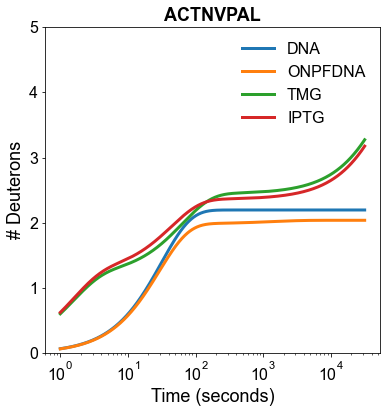

In [4]:
# This section controls the mutation information.

peptide_range = range(peptide_first_res, peptide_last_res + 1, 1)

print('''
-------- Mutational phenotype data from Markiewicz et al., J. Mol Biol., 1994 --------
''')

peptide_index = 0

for residue in peptide_range:
    no_effect = []
    small_effect = []
    dramatic_effect = []
    
    # print MH group
    for key, value in MH_dict.items(): 
        if residue == key:
            peptide_index = peptide_index + 1
            res_label = str(peptide_input[peptide_index-1]) + str(residue)
            print('\n' + res_label + ': group ' + value)
            # print MH group description
            for second_key, second_value in MHdescriptions_dict.items():
                if value == second_key:
                    print(second_value)
                    
    # group and print phenotype effects of specific point mutations
    for key, value in mutation_dict.items():
        if res_label in key:
            if value == '+':
                no_effect.append(key[-1])
            elif value == ('-+' or '+-'):
                small_effect.append(key[-1])
            elif value == '-':
                dramatic_effect.append(key[-1])
                
    print('Mutations that do not affect the phenotype: ' + " ".join(x for x in no_effect))
    print('Mutations causing small effects on phenotype: ' + " ".join(x for x in small_effect))
    print('Mutations causing dramatic effects on phenotype: ' + " ".join(x for x in dramatic_effect))


# This section controls the plot.

print('''
-------- Fitted D uptake plots for selected states with structural representation --------
''')

title = str(peptide_df["peptide"])
title = title.split(' ')[4]
title = title.split('Name')[0]

figure = {'titlesize' : 'large',
          'figsize'   : (6, 6)
         }

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16
       }
axes = {'titlesize' : 18,
        'titleweight' : 'bold',
        'labelsize' : 18
       }

plt.rc('figure', **figure)
plt.rc('font', **font)
plt.rc('axes', **axes)
plt.rc('lines', lw = 3)

plt.xscale('log')
plt.xlabel('Time (seconds)')
plt.ylabel('# Deuterons')
plt.ylim(0,int(N))
plt.title(title[:-1])

for state in states_list:
    plt.plot(t, fit_dict.get(state), label = state)
    
plt.legend(frameon=False)

# This section controls the structure widget.

view = nv.NGLWidget()
traj = pt.load('2p9h_REDO.pdb')
view = nv.show_pytraj(traj)
view.add_surface(str(peptide_first_res) + "-" + str(peptide_last_res), color = 'orange', opacity='0.3', wireframe=True)
view.add_ball_and_stick(str(peptide_first_res) + "-" + str(peptide_last_res))
# view.add_representation('line', selection='water') # uncomment this line to see solvent
view._set_size('400px', '400px')
mat = [59.476009917035874 ,66.10295214971443, -76.02228809508843, 0,
       -55.56959630110223, 95.16365469618486, 39.27191257844691, 0,
       84.029807431962, 16.14505706800799, 79.77915091670029, 0, 
       -22.46560287475586, 17.614827632904053, -10.28352165222168, 1]
view._set_camera_orientation(mat)
print('''
PDB ID: 2P9H (wild-type LacI core domain + IPTG). 
Oriented with the C-terminal subdomain at the top.

Use the mouse to move the structure. 
Double-click for full-screen. Type "R" to zoom out, "I" to rotate, and "K" to rock.
NGLViewer, an amazing tool: H Nguyen, DA Case and AS Rose, Bioinformatics, 2017. doi:10.1093/bioinformatics/btx789
''')
print('Peptide ' + title[:-1] + ', residues ' + str(peptide_first_res) + "-" + str(peptide_last_res) + 
      ', shown as orange surface and sticks.')
view

### Determine the statistical difference in H/D exchange over this timecourse among states for this peptide.

In [5]:
# compare_states_input = str(input("Enter two states to compare, separated by a comma: "))
# compare_states_input = compare_states_input.upper()
# compare_states_input = compare_states_input.replace(" ", "")
# compare_states_list = compare_states_input.split(',')

# states_diff = [0]

# zipped_states_diff = zip(fit_dict.get(compare_states_list[0]), fit_dict.get(compare_states_list[1]))
# for list1_i, list2_i in zipped_states_diff:
#     states_diff.append(list1_i-list2_i)
    
# max_diff = len(t)*N

# percent_diff = ((sum(states_diff)/max_diff) * 100)

# if (percent_diff < 0).bool():
#     percent_diff = -(percent_diff)
#     print('The ' + compare_states_list[1] + ' state exchanges ' + "%.2f" % percent_diff + 
#           '% more than the ' + compare_states_list[0] + ' state over this timecourse.')

# else:
#     print('The ' + compare_states_list[0] + ' state exchanges ' + "%.2f" % percent_diff + 
#           '% more than the ' + compare_states_list[1] + ' state over this timecourse.')

print('''
Independent t-tests
Pairwise tests to determine: is a similar to b? / is a similar to c? / is b similar to c?/ etc.
These test the null hypothesis that pairs of independent samples have identical average (expected) values.
Assumes that the populations have identical variances.
''')

for list1, list2 in combinations(fit_dict.keys(), 2):
    t_val, p_val = ttest_ind(fit_dict[list1], fit_dict[list2])
    print(list1, list2, p_val)

print('''
One-way ANOVA
A combined test to determine: are a, b and c drawn from the same group?
This tests the null hypothesis that all groups have the same population mean.
(If there are only two groups, it's the same as a t-test.)
''')

t_val_2, p_val_2 = f_oneway(*fit_dict.values())
print(*fit_dict.keys(), p_val_2)


Independent t-tests
Pairwise tests to determine: is a similar to b? / is a similar to c? / is b similar to c?/ etc.
These test the null hypothesis that pairs of independent samples have identical average (expected) values.
Assumes that the populations have identical variances.

DNA ONPFDNA 0.0006532924467064519
DNA TMG 6.3930204736033304e-43
DNA IPTG 2.2749571443133823e-44
ONPFDNA TMG 2.990176728774982e-71
ONPFDNA IPTG 1.1556141458829074e-74
TMG IPTG 0.7706230141369828

One-way ANOVA
A combined test to determine: are a, b and c drawn from the same group?
This tests the null hypothesis that all groups have the same population mean.
(If there are only two groups, it's the same as a t-test.)

DNA ONPFDNA TMG IPTG 3.5234391699187416e-112
